In [55]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.signal

# !pip install pint
from pint import UnitRegistry
units = UnitRegistry(system = "mks")
units.default_format = "~P.2e"

### Constants and parameters

In [56]:
mu_0 = 1 * units.vacuum_permeability
N = 100
l = 18 * units.millimeter
R = 34 * units.millimeter / 2
I = 0.5 * units.amp
magnet_dipole = 0.44 * units.amp * units.meter ** 2
z = np.linspace(0 * units.mm, 100 * units.mm, 1000)
m = 9 * units.gram
g = 1 * units.standard_gravity
Fg = m * g

### B field equations

In [57]:
B_z_axis = mu_0 * N * I / 2 * (((l / 2 - z) / (l * np.sqrt(R ** 2 + (l / 2 - z) ** 2))) + ((l / 2 + z) / (l * np.sqrt(R ** 2 + (l / 2 + z) ** 2))))
dBdz = np.diff(B_z_axis, prepend = B_z_axis[0]) / np.diff(z, prepend = z[0])
F_z_axis = magnet_dipole * dBdz

B_short_solenoid_eq = mu_0 * I * N * R ** 2 / (2 * (R ** 2 + z ** 2) ** (3 / 2)) # From wikipedia: https://en.wikipedia.org/wiki/Solenoid#Short_solenoid_estimate
F_short_solenoid_eq = -3 * mu_0 * R ** 2 * N * I * z / (2 * (R ** 2 + z ** 2) ** (5 / 2)) * magnet_dipole # From: https://www.physicsforums.com/insights/how-to-model-a-magnet-falling-through-a-conducting-pipe/

c:\Users\ieykamp\AppData\Local\Programs\Python\Python310\lib\site-packages\pint\facets\plain\quantity.py:998: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


### Linearizing the force

c:\Users\ieykamp\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook.py:1345: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


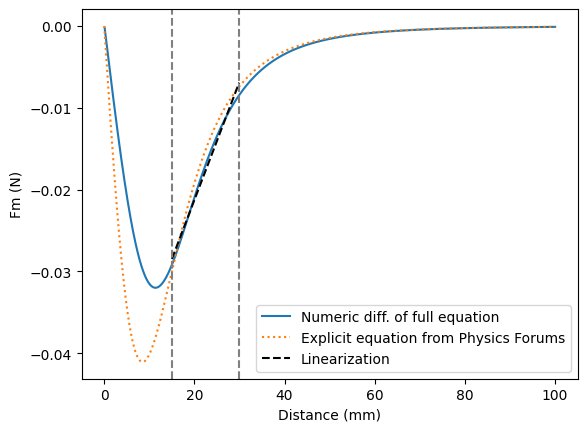

In [58]:
def linreg(x, y):
    A = np.vstack([x.magnitude, np.ones(len(x))]).T
    slope, intercept = np.linalg.lstsq(A, y.magnitude, rcond=None)[0]
    slope = slope * y.units / x.units
    intercept = intercept * y.units
    return slope, intercept

def linreg_points(x, y, start_lin_reg, end_lin_reg):
    lin_reg_range = (start_lin_reg <= x) & (x <= end_lin_reg)
    new_x = x[lin_reg_range]
    new_y = y[lin_reg_range]
    slope, intercept = linreg(new_x, new_y)
    return new_x, new_x * slope + intercept

start_lin_reg = 15 * units.mm
end_lin_reg = 30 * units.mm
lin_reg_range = (start_lin_reg <= z) & (z <= end_lin_reg)
z_lin_reg, Fm_lin_reg = linreg_points(z, F_z_axis, start_lin_reg, end_lin_reg)

plt.plot(z.to(units.mm), F_z_axis.to(units.newton), label = "Numeric diff. of full equation")
plt.plot(z.to(units.mm), F_short_solenoid_eq.to(units.newton), linestyle = "dotted", label = "Explicit equation from Physics Forums")
plt.plot(z_lin_reg.to(units.mm), Fm_lin_reg.to(units.newton), linestyle = "dashed", color = "black", label = "Linearization")
plt.xlabel("Distance (mm)")
plt.ylabel("Fm (N)")
plt.axvline(x = start_lin_reg.to(units.mm).magnitude, color = "grey", linestyle = "dashed")
plt.axvline(x = end_lin_reg.to(units.mm).magnitude, color = "grey", linestyle = "dashed")
plt.legend(loc = "lower right")

### Calculating Z0 and I0

In [67]:
z0 = 20 * units.mm

Fm_at_z0_given_original_I = np.interp(z0, z_lin_reg, Fm_lin_reg)
print(f"Force at z = z0 = {z0.to(units.mm)} given an original current of {I.to(units.amp)} is {Fm_at_z0_given_original_I.to(units.newton)}")
I0 = Fg / -Fm_at_z0_given_original_I * I
print(f"Current must be set to {I0.to(units.amp)} to achieve steady-state with a gravitational force of {Fg.to(units.N)}")


Force at z = z0 = 2.00×10¹ mm given an original current of 5.00×10⁻¹ A is -2.13e-02 N
Current must be set to 2.07×10⁰ A to achieve steady-state with a gravitational force of 8.83×10⁻² N
